<a href="https://colab.research.google.com/github/dellavecchiaemiliano/Market-Making-and-Risk-Management-on-Equity-Options/blob/main/MR_Project_Group_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INDEX #

1.   IMPORTS
2.   OTC Options

  - Functions
  - Code

3. Listed Options & Our Strategy

  3.0. Forecasted Volatility

  3.1. Load Listed Options Data

  3.2. Setting Out Strategy

      - Functions
      - Code

4. Simulations & Limits Analysis

  - 4.1. Simulations (historical & Monte Carlo)
    - Functions
    - Code
  - 4.2. Hard Limits: Granular Market Limits
    - Functions
    - Code
  - 4.3. Soft Limits: Stress Testing
    - Functions
    - Code
    







# 1. IMPORTS #

In [ ]:
!pip install arch
!pip uninstall yfinance
!pip install yfinance==0.2.54
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import statsmodels.api as sm
import pylab
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm import tqdm
from scipy.linalg import cholesky
from arch import arch_model
print(yf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 7.8 MB/s eta 0:00:00
Found existing installation: yfinance 0.2.52
Uninstalling yfinance-0.2.52:
  Would remove:
    /usr/local/bin/sample
    /usr/local/lib/python3.11/dist-packages/yfinance-0.2.52.dist-info/*
    /usr/local/lib/python3.11/dist-packages/yfinance/*
Proceed (Y/n)? Y
  Successfully uninstalled yfinance-0.2.52
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 2.4 MB/s eta 0:00:00
0.2.54


# 2. OTC Options

## Functions ##

In [ ]:
# Function 1: Black Scholes Formula
def bs_formula(S, K, T, r, q, sigma, option_type):
    d1, d2, nd1, nd2, price = np.nan, np.nan, np.nan, np.nan, np.nan

    if T > 0:
        d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        nd1 = norm(loc = 0 , scale = 1).cdf(d1)
        nd2 = norm(loc = 0 , scale = 1).cdf(d2)

        if option_type == 'c':
            price = S*np.e**(-q*T)*nd1 - K * np.e**(-r*T) * nd2
        elif option_type == 'p':
            price = K * np.e**(-r*T) * (1-nd2) - S*np.e**(-q*T)*(1-nd1)

    return price

# Function 2: Calculation of the option greeks
def bs_greeks(S, K, T, r, q, sigma, option_type):
    if T > 0:
        d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        nd1 = norm(loc = 0 , scale = 1).cdf(d1)
        nd2 = norm(loc = 0 , scale = 1).cdf(d2)

    delta = np.exp(-q*T) * nd1
    gamma = np.exp(-q*T) * (norm(loc = 0 , scale = 1).pdf(d1)) / (sigma*S*np.sqrt(T))
    vega = np.exp(-q*T) * S * np.sqrt(T) * norm(loc = 0 , scale = 1).pdf(d1)
    return delta if option_type == 'c' else delta - 1, gamma, vega


## Code ##

In [ ]:
# Definition of the OTC Options

BTP1 = 0.0476
BTP3 = 0.0444

OTC_options_directory = {
  "OTC_name": ["option1", "option2", "option3", "option4", "option5", "option6", "option7", "option8", "option9", "option10"],
  "OTC_strike": [366, 376, 386, 396, 406, 416, 366, 376, 406, 416],
  "OTC_maturity": [30/365, 30/365, 30/365, 30/365, 30/365, 30/365, 150/365, 150/365, 150/365, 150/365], # Since the numerator is the number of natural days to maturity, we divide by 365
  "OTC_type": ["call","call","call","call","call","call","call","call","call","call"],
  "OTC_volatility": [0.3355, 0.3330, 0.3303, 0.3272, 0.3260, 0.3237, 0.3748, 0.3621, 0.3655, 0.3626], #We use the volatilities of the most similar listed options
  "OTC_contracts": [1,1,1,-1,-1,-1,1,1,-1,-1],
  "OTC_rate": [BTP1, BTP1, BTP1, BTP1, BTP1, BTP1, BTP3, BTP3, BTP3, BTP3]
  }


OTC_options = pd.DataFrame(OTC_options_directory)
OTC_options['OTC_contracts'] = OTC_options['OTC_contracts']*900

# Pricing by using the Black Scholes formula

S, q = 366.489990234375, 0
OTC_options["OTC_price"] = OTC_options.apply(
    lambda row: bs_formula(S, row["OTC_strike"], row["OTC_maturity"], row["OTC_rate"], q, row["OTC_volatility"], row["OTC_type"][0]),
    axis=1
)

# Greeks

deltas, gammas, vegas = [], [], []
S, q, = 366.489990234375, 0
for i in range(len(OTC_options)):
    row = OTC_options.iloc[i]
    delta, gamma, vega = bs_greeks(S, row["OTC_strike"], row["OTC_maturity"], row["OTC_rate"], q, row["OTC_volatility"], row["OTC_type"][0])
    deltas.append(delta)
    gammas.append(gamma)
    vegas.append(vega/100)

OTC_options['Delta'] = deltas
OTC_options['Gamma'] = gammas
OTC_options['Vega'] = vegas

# Outcome

OTC_options

,OTC_name,OTC_strike,OTC_maturity,OTC_type,OTC_volatility,OTC_contracts,OTC_rate,OTC_price,Delta,Gamma,Vega
0,option1,366,0.082192,call,0.3355,900,0.0476,15.001223,0.540890,0.011258,0.416963
1,option2,376,0.082192,call,0.3330,900,0.0476,10.447831,0.428723,0.011220,0.412458
2,option3,386,0.082192,call,0.3303,900,0.0476,6.956978,0.323095,0.010346,0.377247
3,option4,396,0.082192,call,0.3272,-900,0.0476,4.407762,0.230573,0.008845,0.319485
4,option5,406,0.082192,call,0.3260,-900,0.0476,2.702258,0.157002,0.007016,0.252494
5,option6,416,0.082192,call,0.3237,-900,0.0476,1.565541,0.100825,0.005191,0.185504
6,option7,366,0.410959,call,0.3748,900,0.0444,38.373777,0.579903,0.004439,0.918421
7,option8,376,0.410959,call,0.3621,900,0.0444,32.649596,0.533594,0.004673,0.933959
8,option9,406,0.410959,call,0.3655,-900,0.0444,21.858861,0.404418,0.004512,0.910253
9,option10,416,0.410959,call,0.3626,-900,0.0444,18.669994,0.363017,0.004404,0.881473


# 3. Listed Options & Our Strategy #

## 3.0. Forecasted Volatility ##

### Importing libraries

In [ ]:
import warnings
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas_datareader.data as pdr
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Importing Data

In [ ]:
CHTR = pdr.DataReader('SP500_CHTR', 'fred',start='2022-01-01', end='2024-10-31').dropna()
CHTR_test = pdr.DataReader('SP500_CHTR', 'fred',start='2022-01-01', end='2024-11-20').dropna()
CHTR['LnRet']=np.log(CHTR) - np.log(CHTR.shift(1))
returnsCHTR = CHTR.LnRet[1:]
sq_ret = returnsCHTR**2
test_ret = np.log(CHTR_test) - np.log(CHTR_test.shift(1))

### Checking for Stationary

In [ ]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print("Augmented Dickey-Fuller Test Results:")  #H0: The series has a trend
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")

    if result[1] < 0.05:
        print("\nConclusion: The time series is stationary (reject H0).")
    else:
        print("\nConclusion: The time series is not stationary (fail to reject H0).")

adf_test(returnsCHTR)

Augmented Dickey-Fuller Test Results:
ADF Statistic: -26.20354682485863
p-value: 0.0
Critical Values:
   1%: -3.439593802573824
   5%: -2.865619356068967
   10%: -2.568942332870462

Conclusion: The time series is stationary (reject H0).


### Checking for correlation in squared returns

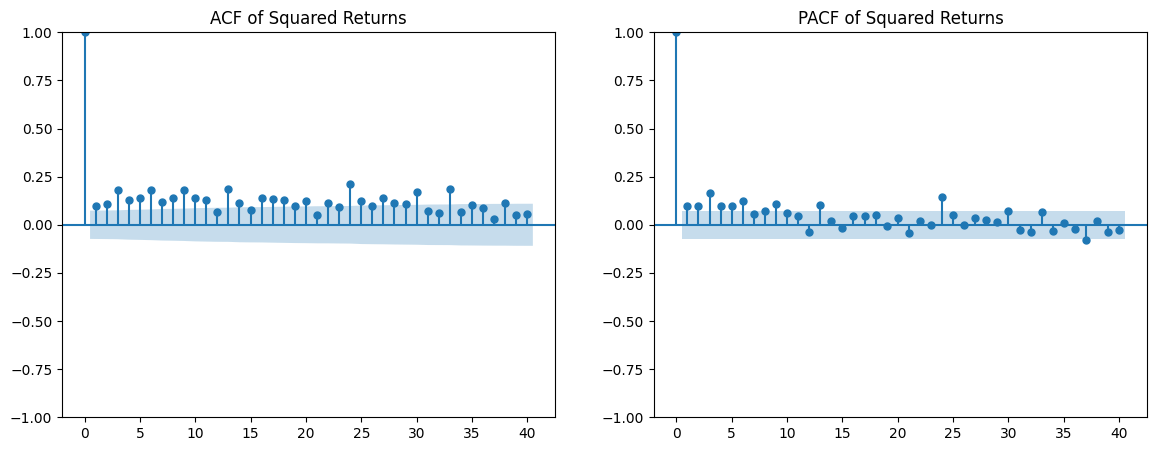

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(sq_ret, ax=ax[0], lags=40)
ax[0].set_title("ACF of Squared Returns")

plot_pacf(sq_ret, ax=ax[1], lags=40)
ax[1].set_title("PACF of Squared Returns")

plt.show()

### Model specification

In [ ]:
warnings.filterwarnings("ignore")  # Ignore warnings for cleaner output

# Define the range of (p, q) values to test
p_values = range(1, 4)  # ARCH terms
q_values = range(1, 4)  # GARCH terms

aic_results = []

# Loop through all (p, q) combinations
for p, q in itertools.product(p_values, q_values):
    try:
        model = arch_model(returnsCHTR, vol="GARCH", p=p, q=q, dist="ged")
        result = model.fit(disp="off")  # Fit model without printing output
        aic_results.append((p, q, result.aic))
    except:
        continue  # Skip models that fail to converge

# Convert results to a DataFrame
aic_df = pd.DataFrame(aic_results, columns=["p", "q", "AIC"])
best_model = aic_df.loc[aic_df["AIC"].idxmin()]  # Find best (p, q)

# Print best model
print(f"Best GARCH Model: GARCH({best_model.p}, {best_model.q}), with AIC = {best_model.AIC}")

# Fit the best model
optimal_garch = arch_model(returnsCHTR, vol="Garch", p=int(best_model.p), q=int(best_model.q), dist="ged").fit(disp="off")

# Print summary
print(optimal_garch.summary())

Best GARCH Model: GARCH(2.0, 1.0), with AIC = -4514.805499870055
                           Constant Mean - GARCH Model Results                            
Dep. Variable:                              LnRet   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:                2263.40
Distribution:      Generalized Error Distribution   AIC:                          -4514.81
Method:                        Maximum Likelihood   BIC:                          -4487.41
                                                    No. Observations:                  711
Date:                            Thu, Feb 20 2025   Df Residuals:                      710
Time:                                    17:20:42   Df Model:                            1
                                 Mean Model                                 
                 coef    std err       

#### Looking for correlation and normality of standardized residuals

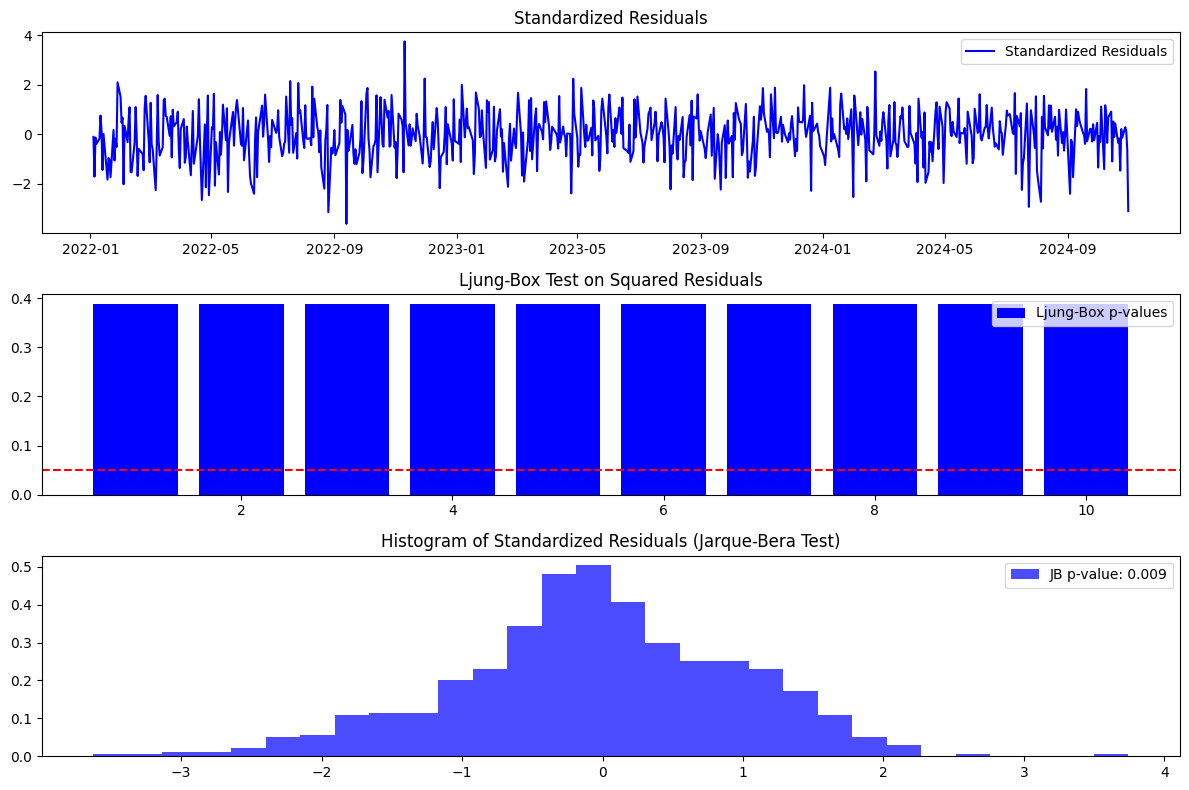

Ljung-Box p-value (10 lags): 0.3894
Jarque-Bera p-value: 0.0088
No significant autocorrelation in squared residuals (GARCH model is well-specified).
Residuals are not normal!


In [ ]:
# Get standardized residuals
std_resid = optimal_garch.resid / optimal_garch.conditional_volatility

# Plot standardized residuals
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

ax[0].plot(std_resid, label="Standardized Residuals", color='blue')
ax[0].set_title("Standardized Residuals")
ax[0].legend()

# Ljung-Box Test (Autocorrelation in squared residuals)
lb_test = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)
ax[1].bar(range(1, 11), lb_test["lb_pvalue"], color="blue", label="Ljung-Box p-values")
ax[1].axhline(y=0.05, color="r", linestyle="--")  # 5% significance level
ax[1].set_title("Ljung-Box Test on Squared Residuals")
ax[1].legend()

# Jarque-Bera Test (Normality)
jb_stat, jb_p = stats.jarque_bera(std_resid)
ax[2].hist(std_resid, bins=30, color='blue', alpha=0.7, density=True, label=f"JB p-value: {jb_p:.3f}")
ax[2].set_title("Histogram of Standardized Residuals (Jarque-Bera Test)")
ax[2].legend()

plt.tight_layout()
plt.show()

# Print Ljung-Box and Jarque-Bera results
print(f"Ljung-Box p-value (10 lags): {lb_test['lb_pvalue'].values[-1]:.4f}")
print(f"Jarque-Bera p-value: {jb_p:.4f}")

# Interpretation:
if lb_test['lb_pvalue'].values[-1] > 0.05:
    print("No significant autocorrelation in squared residuals (GARCH model is well-specified).")
else:
    print("Significant autocorrelation detected!")

if jb_p > 0.05:
    print("Residuals appear normally distributed.")
else:
    print("Residuals are not normal!")

### Fitting GARCH(4,1)
Although the algorithm convereged to a GARCH(2,1). We found out that a GARCH(4,1) with Generalized Error Distribution has the third and the fourth parameters of the ARCH component statistically significant, this means that it captures the impact of past squares returns on volatility better than the GARCH(2,1). Furthermore, it has AIC equal to minimum AIC and BIC very close to the minimum.

In [ ]:
# Fit GARCH(4,1) model with ged distribution
garch = arch_model(returnsCHTR, vol='GARCH', p=4, q=1, dist='ged').fit(disp='off')

# Print summary
print(garch.summary())

                           Constant Mean - GARCH Model Results                            
Dep. Variable:                              LnRet   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:                2264.51
Distribution:      Generalized Error Distribution   AIC:                          -4513.02
Method:                        Maximum Likelihood   BIC:                          -4476.49
                                                    No. Observations:                  711
Date:                            Thu, Feb 20 2025   Df Residuals:                      710
Time:                                    17:20:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------

#### Looking for correlation and Normality of standardized residuals
The higher p-value of the Ljung-Box test confirm the hypothesis that the model is better specified.

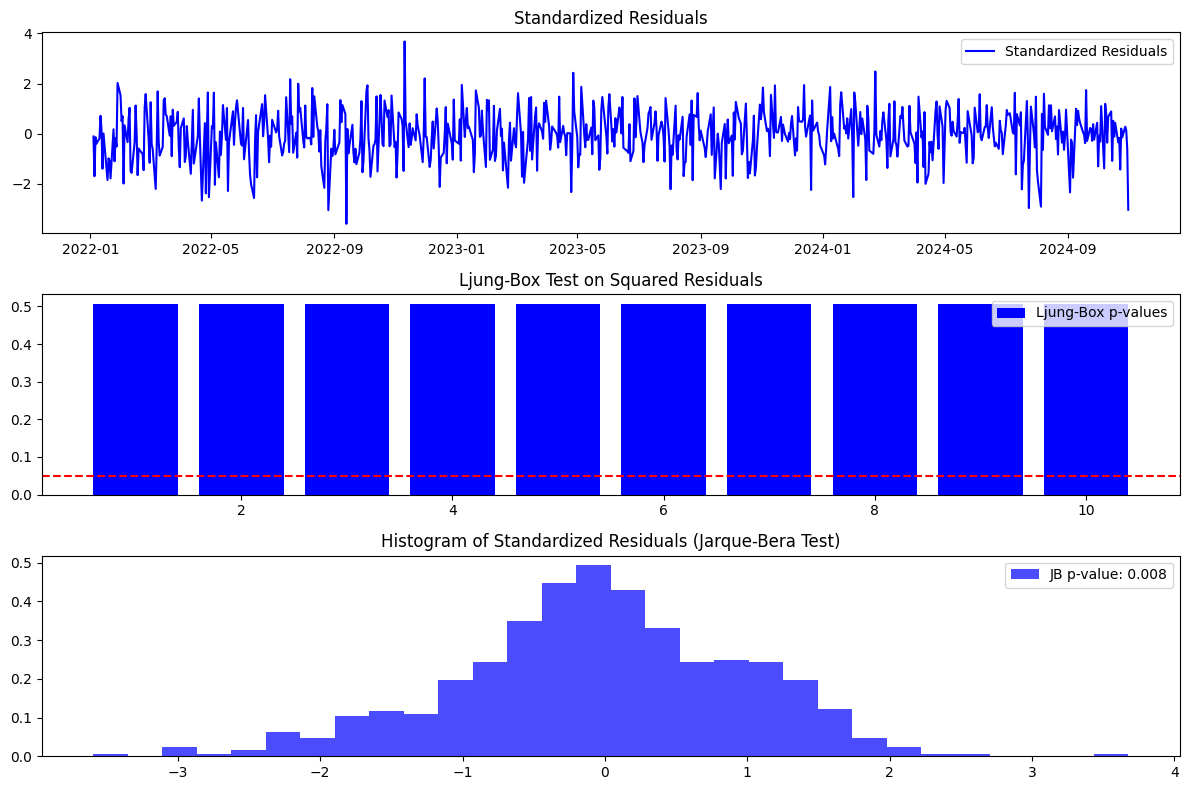

Ljung-Box p-value (10 lags): 0.5076
Jarque-Bera p-value: 0.0083
No significant autocorrelation in squared residuals (GARCH model is well-specified).
Residuals are not normal!


In [ ]:
std_res = garch.resid / garch.conditional_volatility

# Plot standardized residuals
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

ax[0].plot(std_res, label="Standardized Residuals", color='blue')
ax[0].set_title("Standardized Residuals")
ax[0].legend()

# Ljung-Box Test (Autocorrelation in squared residuals)
lb_test = acorr_ljungbox(std_res**2, lags=[10], return_df=True)
ax[1].bar(range(1, 11), lb_test["lb_pvalue"], color="blue", label="Ljung-Box p-values")
ax[1].axhline(y=0.05, color="r", linestyle="--")  # 5% significance level
ax[1].set_title("Ljung-Box Test on Squared Residuals")
ax[1].legend()

# Jarque-Bera Test (Normality)
jb_stat, jb_p = stats.jarque_bera(std_res)
ax[2].hist(std_res, bins=30, color='blue', alpha=0.7, density=True, label=f"JB p-value: {jb_p:.3f}")
ax[2].set_title("Histogram of Standardized Residuals (Jarque-Bera Test)")
ax[2].legend()

plt.tight_layout()
plt.show()

# Print Ljung-Box and Jarque-Bera results
print(f"Ljung-Box p-value (10 lags): {lb_test['lb_pvalue'].values[-1]:.4f}")
print(f"Jarque-Bera p-value: {jb_p:.4f}")

# Interpretation:
if lb_test['lb_pvalue'].values[-1] > 0.05:
    print("No significant autocorrelation in squared residuals (GARCH model is well-specified).")
else:
    print("Significant autocorrelation detected! Consider modifying the model.")

if jb_p > 0.05:
    print("Residuals appear normally distributed.")
else:
    print("Residuals are not normal!")

### Forecasting conditional volatility

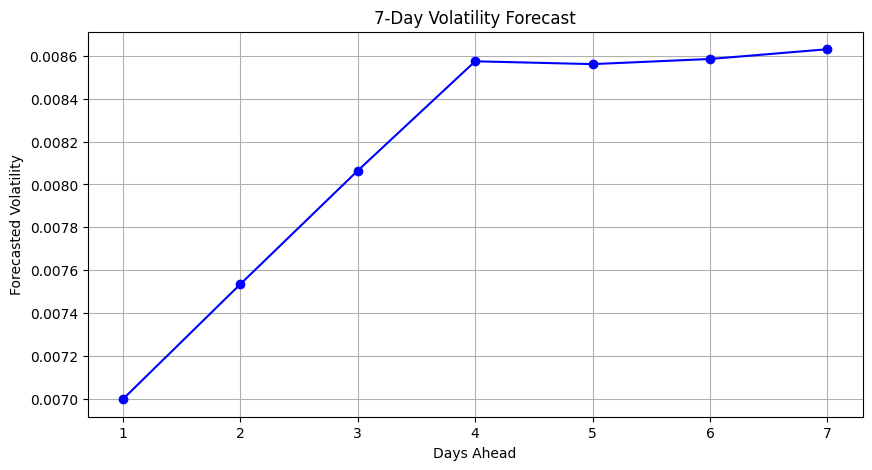

Forecasted Volatility for the Next 7 Days:
Day 1: 0.006998
Day 2: 0.007535
Day 3: 0.008064
Day 4: 0.008574
Day 5: 0.008561
Day 6: 0.008585
Day 7: 0.008630


In [ ]:
forecast_horizon = 7

# Generate volatility forecast
garch_forecast = garch.forecast(horizon=forecast_horizon, method='analytic')

# Extract conditional variance forecast (volatility squared)
forecasted_volatility = np.sqrt(garch_forecast.variance.iloc[-1].values)

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(range(1, forecast_horizon + 1), forecasted_volatility, marker="o", linestyle="-", color="blue")
plt.xlabel("Days Ahead")
plt.ylabel("Forecasted Volatility")
plt.title(f"{forecast_horizon}-Day Volatility Forecast")
plt.grid()
plt.show()

# Print forecast values
print("Forecasted Volatility for the Next 7 Days:")
for i, vol in enumerate(forecasted_volatility):
    print(f"Day {i+1}: {vol:.6f}")

        Date  Forecasted Volatility
0 2024-11-01               0.006998
1 2024-11-04               0.007535
2 2024-11-05               0.008064
3 2024-11-06               0.008574
4 2024-11-07               0.008561
5 2024-11-08               0.008585
6 2024-11-11               0.008630


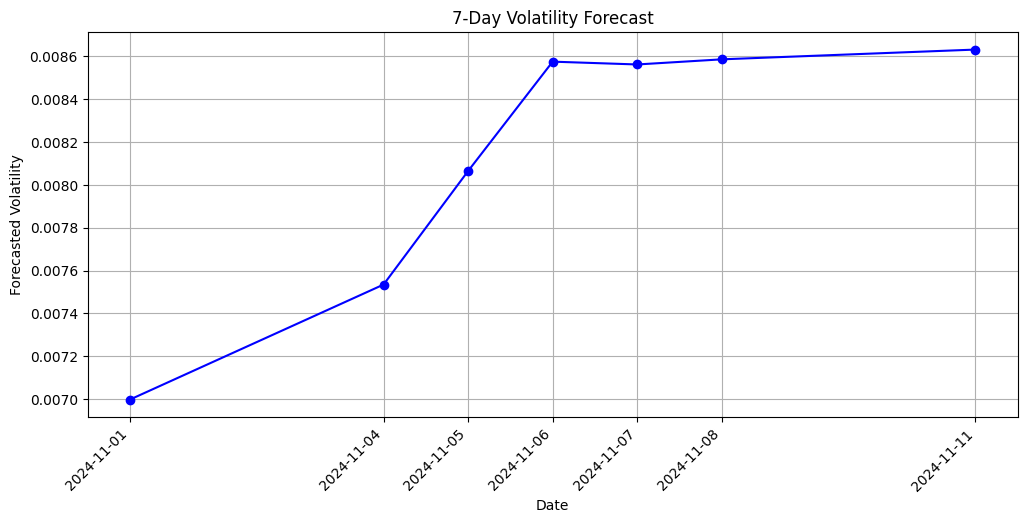

In [ ]:
# Get the last available date in the dataset
last_date = returnsCHTR.index[-1]

# Generate future dates (only business days)
forecast_dates = pd.date_range(start=last_date, periods=forecast_horizon + 1, freq='B')[1:]  # Skip last known date

# Create a DataFrame with forecasted dates and volatility
forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Forecasted Volatility": forecasted_volatility
})

print(forecast_df)

# Plot forecasted volatility
plt.figure(figsize=(12, 5))
plt.plot(forecast_df["Date"], forecast_df["Forecasted Volatility"], marker="o", linestyle="-", color="blue")
plt.xticks(forecast_df["Date"], rotation=45, ha='right')  # Rotate for better visibility
plt.xlabel("Date")
plt.ylabel("Forecasted Volatility")
plt.title(f"{forecast_horizon}-Day Volatility Forecast")
plt.grid()
plt.show()

### Model performance evaluation

In [ ]:
# Define the rolling window for realized volatility
rolling_window = 30

# Compute historical realized volatility (30-day rolling standard deviation of returns)
historical_volatility = test_ret.rolling(window=rolling_window).std()

# Save historical volatility as a DataFrame
historical_vol_df = pd.DataFrame({
    "Date": test_ret.index,
    "Historical Volatility": historical_volatility.values.flatten()
})

historical_vol_df.dropna(inplace=True)

print(historical_vol_df.tail(20))

          Date  Historical Volatility
706 2024-10-24               0.005954
707 2024-10-25               0.005908
708 2024-10-28               0.005915
709 2024-10-29               0.005913
710 2024-10-30               0.005923
711 2024-10-31               0.006231
712 2024-11-01               0.006265
713 2024-11-04               0.006267
714 2024-11-05               0.006641
715 2024-11-06               0.008009
716 2024-11-07               0.008073
717 2024-11-08               0.008071
718 2024-11-11               0.008054
719 2024-11-12               0.007841
720 2024-11-13               0.007840
721 2024-11-14               0.007943
722 2024-11-15               0.008250
723 2024-11-18               0.008033
724 2024-11-19               0.007891
725 2024-11-20               0.007807


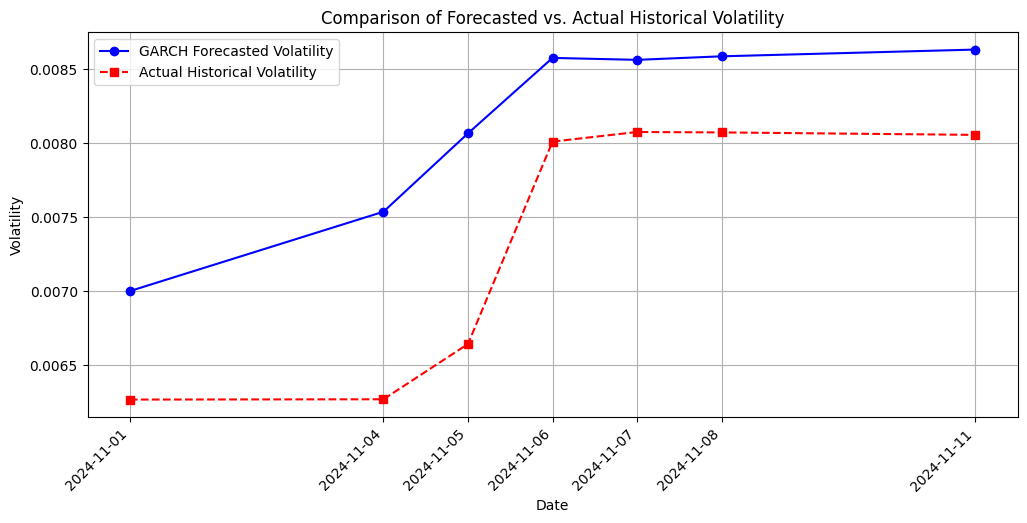

Model Performance Metrics:
Mean Absolute Error (MAE): 0.000795
Root Mean Square Error (RMSE): 0.000872
        Date  Forecasted Volatility  Historical Volatility
0 2024-11-01               0.006998               0.006265
1 2024-11-04               0.007535               0.006267
2 2024-11-05               0.008064               0.006641
3 2024-11-06               0.008574               0.008009
4 2024-11-07               0.008561               0.008073


In [ ]:
historical_vol_for_comparison = historical_vol_df.set_index("Date").loc[forecast_df["Date"]]

# Add historical realized volatility to the forecast DataFrame
forecast_df["Historical Volatility"] = historical_vol_for_comparison.values

# Plot the comparison
plt.figure(figsize=(12, 5))
plt.plot(forecast_df["Date"], forecast_df["Forecasted Volatility"], marker="o", linestyle="-", label="GARCH Forecasted Volatility", color="blue")
plt.plot(forecast_df["Date"], forecast_df["Historical Volatility"], marker="s", linestyle="--", label="Actual Historical Volatility", color="red")
plt.xticks(forecast_df["Date"], rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Comparison of Forecasted vs. Actual Historical Volatility")
plt.legend()
plt.grid()
plt.show()

# Evaluate model performance
mae = mean_absolute_error(forecast_df["Historical Volatility"], forecast_df["Forecasted Volatility"])
rmse = np.sqrt(mean_squared_error(forecast_df["Historical Volatility"], forecast_df["Forecasted Volatility"]))

# Print accuracy metrics
print(f"Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Square Error (RMSE): {rmse:.6f}")

# Display the comparison table
print(forecast_df.head())  # Show the first few rows

## 3.1. Load Listed Options Data

In [ ]:
# Load the data from an excel
# Options data retrieved from Bloomberg on November 1

listed_options = pd.read_excel('/content/listed_options_clean_data_0111.xlsx')
#listed_options = pd.read_excel("listed_options_clean_data_0111.xlsx")

# Fix the risk-free rate
r=0.047

# Perform some transformations including the creation of new columns
listed_options.drop(columns=['Ultimo', 'Volm','Bid'], inplace=True)
listed_options = listed_options.rename(columns={"Ask": "Listed_price"})
listed_options['Type'] = listed_options['Type'].apply(lambda x: 'call' if x.lower() == 'call' else 'put')
listed_options['Date'] = date(2024,11,1)
listed_options['Maturity_years'] = listed_options['Maturity']/365
listed_options['r'] = r

S, q = 366.489990234375, 0
listed_options["BS_price"] = listed_options.apply(
    lambda row: bs_formula(S, row["Strike"], row["Maturity_years"], r, q, row["IVM"]/100, row["Type"][0]),
    axis=1
)
deltas, gammas, vegas = [], [], []
S, q  = 366.489990234375, 0
for i in range(len(listed_options)):
    row = listed_options.iloc[i]
    delta, gamma, vega = bs_greeks(S, row["Strike"], row["Maturity_years"], r, q, row["IVM"]/100, row["Type"][0])
    deltas.append(delta)
    gammas.append(gamma)
    vegas.append(vega/100)

listed_options['Delta'] = deltas
listed_options['Gamma'] = gammas
listed_options['Vega'] = vegas

# Outcome
listed_options

,Type,Maturity,Strike,Ticker,Listed_price,IVM,Date,Maturity_years,r,BS_price,Delta,Gamma,Vega
0,call,11,355,CHTR 11/15/24 C355,26.699997,31.561792,2024-11-01,0.030137,0.047,15.284068,0.737157,0.016244,0.207525
1,call,11,360,CHTR 11/15/24 C360,23.500000,34.666615,2024-11-01,0.030137,0.047,12.656825,0.637024,0.017010,0.238695
2,call,11,365,CHTR 11/15/24 C365,19.800003,41.505848,2024-11-01,0.030137,0.047,11.537587,0.544677,0.015013,0.252225
3,call,11,370,CHTR 11/15/24 C370,15.500000,33.761520,2024-11-01,0.030137,0.047,7.192120,0.456538,0.018462,0.252310
4,call,11,375,CHTR 11/15/24 C375,13.000000,39.509315,2024-11-01,0.030137,0.047,6.641183,0.389842,0.015262,0.244079
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,put,438,380,CHTR 1/16/26 P380,56.100006,36.702671,2024-11-01,1.200000,0.047,54.214362,-0.400803,0.002623,1.551861
156,put,438,390,CHTR 1/16/26 P390,60.199997,36.081291,2024-11-01,1.200000,0.047,58.648735,-0.427394,0.002708,1.575033
157,put,438,400,CHTR 1/16/26 P400,69.000000,36.871090,2024-11-01,1.200000,0.047,65.542433,-0.450274,0.002674,1.589174
158,put,438,410,CHTR 1/16/26 P410,71.400009,35.629166,2024-11-01,1.200000,0.047,69.431423,-0.479178,0.002785,1.599450


## 3.2. Setting Our Strategy

### Functions ###

In [ ]:
# Function 3: To computethe number of contracts for the listed options that we need so that our whole portfolio have the desired greeks
def trading_strategy(selected_listed_options, amount, tgt_gamma, tgt_vega):
    w = np.ones(len(selected_listed_options))
    bounds = [WEIGHTS_BOUNDS for _ in range(len(w))]
    result = minimize(obj_function, x0=w, args=(selected_listed_options, amount,tgt_gamma, tgt_vega), \
                                                 constraints=({'type': 'eq', 'fun': lambda x: x.sum() - 1}), \
                                                 bounds=bounds)
    # Note that, the previous lines:
    # In constraints, we set that the sum of the components of the output vector have to be equal to one.
    # Therefore, we set that the amount spent on listed options has to be the same as the value of the portfolio of OTC options.

    optimal_weights = result.x # The vector optimal_weights contains the amount used for each listed option as a percentage respect to the amount obtained from the OTC option
    n_contracts = (optimal_weights * amount) / selected_listed_options['Listed_price'].to_numpy()
    n_contracts_rounded = np.round(n_contracts)

    gamma = calculate_greek(n_contracts_rounded, selected_listed_options, 'Gamma')
    vega = calculate_greek(n_contracts_rounded, selected_listed_options, 'Vega')
    delta = calculate_greek(n_contracts_rounded, selected_listed_options, 'Delta')
    optimal_weights

    return n_contracts, gamma, vega, delta, optimal_weights, n_contracts_rounded

# Function 4: This function is used to minimize the difference between the target greeks and the portfolio greeks by looking for the optimal values of the vector optimal_weights
def obj_function(optimal_weights, selected_listed_options, amount, tgt_gamma, tgt_vega):
    n_contracts = (optimal_weights * amount) / selected_listed_options['Listed_price'].to_numpy()
    gamma = calculate_greek(n_contracts, selected_listed_options, 'Gamma')
    vega = calculate_greek(n_contracts, selected_listed_options, 'Vega')

    return ((vega-tgt_vega)/tgt_vega)**2 + ((gamma-tgt_gamma)/tgt_gamma)**2

# Function 5: Computes the value of a certain greek for the portfolio
def calculate_greek(numbers_of_contracts, selected_listed_options, greek):
    greek_values = selected_listed_options[greek].to_numpy()
    return (greek_values * numbers_of_contracts).sum()

### Code ###

In [ ]:
# Select the listed options that we are interested in for our strategy

selected_options = [
    'CHTR 11/15/24 C355',
    'CHTR 11/15/24 C365',
    'CHTR 11/15/24 C375',
    'CHTR 12/20/24 C340',
    'CHTR 12/20/24 C350',
    'CHTR 12/20/24 C360',
    'CHTR 12/20/24 C370'
]

# Create a dataframe only with the desired listed options
selected_listed_options = listed_options[listed_options['Ticker'].isin(selected_options)]

# Compute the value of the portfolio of OTC options on our side
amount = (OTC_options['OTC_price'] * OTC_options['OTC_contracts']).sum()

# We set the desired values for Gamma and Vega of our whole portfolio, that is, including both OTC and listed options
TARGET_GAMMA = 0.1
TARGET_VEGA =  1000

# We want to set a reasonable amount to buy/sell the listed options.
# So, we have decided not to use more than 10 times the amount of the OTC options porfolio for a single listed option
WEIGHTS_BOUNDS = (-10, 10)

# Calculation greeks of the portfolio of OTC options
OTC_portfolio_delta = - np.sum(OTC_options['Delta']* OTC_options['OTC_contracts'])
OTC_portfolio_gamma = - np.sum(OTC_options['Gamma']* OTC_options['OTC_contracts'])
OTC_portfolio_vega = - np.sum(OTC_options['Vega']* OTC_options['OTC_contracts'])

# We look for the number of contracts for the listed options that we need so that our whole portfolio (with both OTC and listed options) have the desired greeks
n_contracts, gamma, vega, delta, optimal_weights, n_contracts_rounded = trading_strategy(selected_listed_options=selected_listed_options, amount=amount, tgt_gamma = TARGET_GAMMA - OTC_portfolio_gamma, tgt_vega = TARGET_VEGA - OTC_portfolio_vega)

# The following 'print' are for testing purposes
print(f'Rounded mumber of contracts per listed options {n_contracts_rounded}\n')
print(f'NOT rounded Number of contracts per listed options {n_contracts}\n')
print(f'Amount used for each contract as a percentage respect to the amount obtained from the OTC option {optimal_weights} and the sum of these percentatges is {optimal_weights.sum()} \n')


# Final greeks of our whole portfolio
gamma_final = gamma + OTC_portfolio_gamma
vega_final = vega + OTC_portfolio_vega
delta_final = delta + OTC_portfolio_delta

# Calculation of the number of stock shares that we have to buy/sell to hedge Delta.
n_shares = np.round(-delta_final)
# Since we cannot completely hedge delta (it is not possible to buy a decimal number of shares), we compute the final delta of the portfolio
delta_final += n_shares * 1
#n_shares  = - delta_final

print(f'Final delta of the portfolio (resulting from not being able to hedge completely due to rounding) {delta_final}\n')
print(f'Number of shares to hedge delta {n_shares}\n')
print(f'Final vega {vega_final}\n')
print(f'Final gamma {gamma_final}\n')
print(amount)

print(OTC_portfolio_vega)
print(vega)

Rounded mumber of contracts per listed options [-1518.  -827.  1204.   -51.   386.  1185.  1803.]

NOT rounded Number of contracts per listed options [-1518.38174485  -826.89275659  1204.33114698   -50.73147016
   386.41915304  1185.25835318  1803.37048887]

Amount used for each contract as a percentage respect to the amount obtained from the OTC option [-0.83071146 -0.3354845   0.32080955 -0.04979332  0.2969258   0.72617642
  0.87207752] and the sum of these percentatges is 0.9999999999999999 

Final delta of the portfolio (resulting from not being able to hedge completely due to rounding) 0.09173049477590212

Number of shares to hedge delta 274.0

Final vega 999.3079694387743

Final gamma 0.08904800164861193

48802.49027688741
-458.8552029789266
1458.163172417701


In [ ]:
selected_listed_options

,Type,Maturity,Strike,Ticker,Listed_price,IVM,Date,Maturity_years,r,BS_price,Delta,Gamma,Vega
0,call,11,355,CHTR 11/15/24 C355,26.699997,31.561792,2024-11-01,0.030137,0.047,15.284068,0.737157,0.016244,0.207525
2,call,11,365,CHTR 11/15/24 C365,19.800003,41.505848,2024-11-01,0.030137,0.047,11.537587,0.544677,0.015013,0.252225
4,call,11,375,CHTR 11/15/24 C375,13.000000,39.509315,2024-11-01,0.030137,0.047,6.641183,0.389842,0.015262,0.244079
11,call,46,340,CHTR 12/20/24 C340,47.900009,40.098137,2024-11-01,0.126027,0.047,37.375443,0.738861,0.006232,0.422967
12,call,46,350,CHTR 12/20/24 C350,37.500000,35.895382,2024-11-01,0.126027,0.047,28.911541,0.681351,0.007644,0.464445
13,call,46,360,CHTR 12/20/24 C360,29.899994,33.596767,2024-11-01,0.126027,0.047,21.872137,0.602222,0.008826,0.501911
14,call,46,370,CHTR 12/20/24 C370,23.600006,33.558533,2024-11-01,0.126027,0.047,16.785099,0.511678,0.009133,0.518822


# 4. Simulations & Limits Analysis #

## 4.1 Simulations (historical & Monte Carlo) #

### Functions ###

In [ ]:
# Function 6: Get the time series for CHTR and VIX as well as sapply some transformations to it and create new useful columns
def price_and_vol_time_series():

  series_CHTR = yf.download('CHTR', '2021-11-01', '2024-11-04').reset_index().drop(columns=['Open','High','Low','Volume'])
  series_CHTR = series_CHTR.rename(columns={'Close':'Price'})
  series_CHTR['Date'] = pd.to_datetime(series_CHTR['Date']).dt.date

  series_VIX = yf.download('^VIX', '2021-11-01', '2024-11-04').reset_index().drop(columns=['Open','High','Low','Volume'])
  series_VIX = series_VIX.rename(columns={'Close':'VIX'})
  series_VIX['Date'] = pd.to_datetime(series_VIX['Date']).dt.date

  series_total = series_CHTR.merge(series_VIX, how='left', left_on='Date', right_on='Date')


  series_total['returns_CHTR'] = np.log(series_total['Price'])-np.log(series_total['Price'].shift(1))
  series_total['returns_VIX'] = np.log(series_total['VIX'])-np.log(series_total['VIX'].shift(1))
  series_total['5d_returns_CHTR'] = np.log(series_total['Price'])-np.log(series_total['Price'].shift(5))
  series_total['5d_returns_VIX'] = np.log(series_total['VIX'])-np.log(series_total['VIX'].shift(5))

  return series_total

# Funciton 7: Perform the Monte Carlo simulation for the CHTR and VIX
def monte_carlo_simulation(n_simulations, n_days, series_total):
    # Extract the mean and covariances
    mu_s = np.mean(series_total['returns_CHTR'].dropna())
    mu_v = np.mean(series_total['returns_VIX'].dropna())
    cov = np.cov(series_total['returns_CHTR'].dropna(), series_total['returns_VIX'].dropna())

    # Create a vector of means and the Cholesky Decomposition matrix
    mu_vec = np.array([[mu_s],[mu_v]])
    cholesky_matrix = cholesky(cov, lower=True)  # Lower-triangular version

    # Extract current levels (on the trading day)
    current_vix = series_total[series_total['Date'] == date(2024,11,1)]['VIX'].iloc[0].item()
    current_price = series_total[series_total['Date'] == date(2024,11,1)]['Price'].iloc[0].item()

    simulated_CHTR = np.ones(n_simulations)
    simulated_VIX = np.ones(n_simulations)

    # Carry out the Monte Carlo simulation

    for i in range(n_simulations):
        zs = np.random.normal(size=(2,1))
        sim = n_days * mu_vec + np.sqrt(n_days) * cholesky_matrix @ zs

        simulated_CHTR[i] = current_price * np.exp(sim[0,0])
        simulated_VIX[i] = current_vix * np.exp(sim[1,0])

    return simulated_CHTR, simulated_VIX

# Funciton 8: Perform the Historical simulation for the CHTR and VIX
def historical(series_total):
    current_vix = series_total[series_total['Date'] == date(2024,11,1)]['VIX'].iloc[0].item()
    current_price = series_total[series_total['Date'] == date(2024,11,1)]['Price'].iloc[0].item()

    simulated_CHTR = current_price * np.exp(series_total['5d_returns_CHTR'].dropna().to_numpy())
    simulated_VIX = current_vix * np.exp(series_total['5d_returns_VIX'].dropna().to_numpy())

    return simulated_CHTR, simulated_VIX

# Function 9: once we have the simulated values for CHTR and VIX, we can proceed to see how does the value of each option in our portfolio changes in one simulated scenario
# and provide this change in a form vector that contains the change that each option experiences
def option_values_changes(current_CHTR, current_vix, dS, sigma_change, listed_options, OTC_options):
    changes_listed = np.zeros(len(listed_options))
    for j in range(len(listed_options)):
        option = listed_options.iloc[j]
        #last_price = option['Listed_price']
        iv1 = option['IVM']
        iv_listed = (iv1 *( 1 + sigma_change)) / 100 # For the OTC, we use as the change in volatility the one obtained from the simulation of the VIX
        K = option['Strike']
        T = option['Maturity_years'] - n_days/365 # In this case we divide the number of days by 365 because it is natural days
        r = option['r']
        option_type = 'c' if option['Type'] == 'call' else 'p'

        last_price = bs_formula(current_CHTR, K, option['Maturity_years'], r, q, iv1/100, option_type)
        new_price = bs_formula(current_CHTR + dS, K, T, r, q, iv_listed, option_type)

        changes_listed[j] = new_price - last_price.item()

    changes_OTC = np.zeros(len(OTC_options))
    for j in range(len(OTC_options)):
        option = OTC_options.iloc[j]
        last_price = option['OTC_price']
        iv2 = option['OTC_volatility']
        iv_OTC = iv2 * (1 + sigma_change) #In this case only sigma_change has to be divided by 100
        K = option['OTC_strike']
        T = option['OTC_maturity'] - n_days/365 # In this case we divide the number of days by 365 because it is natural days
        r = option['OTC_rate']
        option_type = 'c' if option['OTC_type'] == 'call' else 'p'

        new_price = bs_formula(current_CHTR + dS, K, T, r, q, iv_OTC, option_type)


        changes_OTC[j] = new_price - last_price.item()

    return np.hstack((changes_listed, changes_OTC))

### Code ###

In [ ]:
# CODE PART 1
# Setting of variables
n_simulations = 2000
n_days = 5

# Get the historical data for the stock and the VIX
series_total = price_and_vol_time_series()

# Determine current values (on trading date) of the stock and the VIX
current_CHTR = series_total[series_total['Date'] == date(2024,11,1)]['Price'].iloc[0].item()
current_vix = series_total[series_total['Date'] == date(2024,11,1)]['VIX'].iloc[0].item()

# Simulate scenarios for the stock and the VIX
# Choose between historical simulation or Monte Carlo (by activating/desactivating the code)

#simulated_CHTR, simulated_VIX = historical(series_total)
simulated_CHTR, simulated_VIX = monte_carlo_simulation(n_simulations, n_days, series_total)

# Get the changes in the value of each option for each simulated scenario and store the data in a matrix.
changes_matrix = np.zeros(shape=(len(simulated_CHTR), len(selected_listed_options)+len(OTC_options)+1))
for i in tqdm(range(len(simulated_CHTR))):
    dS = simulated_CHTR[i].item() - current_CHTR
    sigma_change = (simulated_VIX[i] - current_vix)/current_vix

    option_values = option_values_changes(current_CHTR=current_CHTR, current_vix=current_vix, \
                                                  dS=dS, sigma_change=sigma_change, \
                                                  listed_options=selected_listed_options, OTC_options=OTC_options)
    changes_matrix[i,:] = np.hstack((option_values,np.array([dS])))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
100%|██████████| 2000/2000 [01:57<00:00, 17.08it/s]


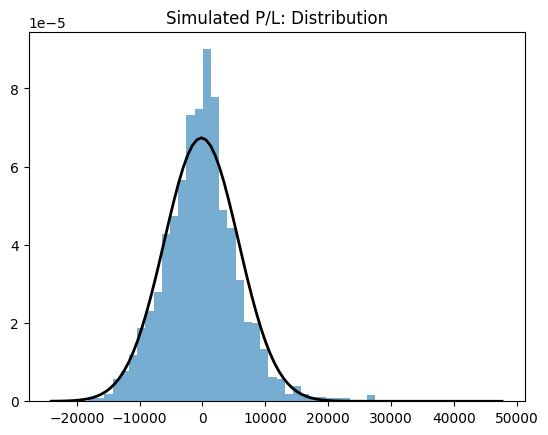

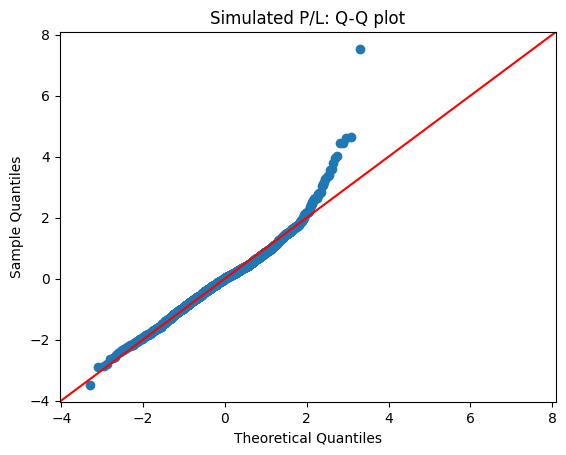

In [ ]:
# CODE PART 2
# Obtain the allocation (number of contracts) of our portfolio
allocation = np.hstack((n_contracts_rounded, -OTC_options["OTC_contracts"], np.array([n_shares])))
profit_losses = changes_matrix @ allocation


# Plot the Distribution of losses
# Plot the histogram
plt.hist(profit_losses, bins=50, density=True, alpha=0.6)

# Plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
mu, std = norm.fit(profit_losses)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
plt.title('Simulated P/L: Distribution')
plt.show()

# Plot the Q-Q plot
z = (profit_losses - np.mean(profit_losses)) / np.std(profit_losses)
sm.qqplot(z, line='45')
plt.title('Simulated P/L: Q-Q plot')
pylab.show()

## 4.2 Hard Limits: Granular Market Limits ##

### Functions ###

In [ ]:
# Function 10: used to compute how the porfolio would react to certain changes.
# That is, it computes the impact on the portfolio in front of different scenarios (All Markets changes and Volatility changes)
def sensitivities(current_CHTR, current_vix, listed_options, OTC_options, n_contracts):
    allmkt_changes = [0.01, 0.1, -0.1]

    for allmkt_change in allmkt_changes:
        dS = allmkt_change * current_CHTR
        option_prices = option_values_changes(current_CHTR=current_CHTR, current_vix=current_vix, \
                                                  dS=dS, sigma_change=0, \
                                                  listed_options=listed_options, OTC_options=OTC_options)

        option_prices = np.hstack((option_prices, np.array([dS])))
        effect = option_prices * n_contracts

        long_pos = np.maximum(0, n_contracts)
        short_pos = np.minimum(0, n_contracts)

        long_effect = (option_prices * long_pos).sum().round()
        short_effect = (option_prices * short_pos).sum().round()

        print(f'All Mkt {100*allmkt_change}%: {effect.sum().round()} \t(Gross effect LONG: {long_effect}, Gross effect SHORT: {short_effect})')


    vola_changes = [1.0, 25.0, -25.0]
        # For Volatility change 25%, limit: -225


    for vola_change in vola_changes:
        option_prices = option_values_changes(current_CHTR=current_CHTR, current_vix=current_vix, \
                                                  dS=0, sigma_change=vola_change/100, \
                                                  listed_options=listed_options, OTC_options=OTC_options)

        option_prices = np.hstack((option_prices, np.array([0]))) # In here, the we consider the change in the value of the stock  zero
        effect = option_prices * n_contracts

        long_pos = np.maximum(0, n_contracts)
        short_pos = np.minimum(0, n_contracts)

        long_effect = (option_prices * long_pos).sum().round()
        short_effect = (option_prices * short_pos).sum().round()

        print(f'Vola {vola_change}%: {effect.sum().round()} \t(Gross effect LONG: {long_effect}, Gross effect SHORT: {short_effect})')


### Code ###

In [ ]:
# Compute the 95% VaR values
var_total_95 = np.quantile(profit_losses, 0.05)
print(f' 95% VaR: {var_total_95.round()}\n')

# Analysis of the sensitivity of the portfolio with respect to All Market and Volatility changes.
sensitivities(current_CHTR, current_vix, listed_options=selected_listed_options, OTC_options=OTC_options, n_contracts=allocation)

 95% VaR: -9794.0

All Mkt 1.0%: -737.0 	(Gross effect LONG: 4119.0, Gross effect SHORT: -4856.0)
All Mkt 10.0%: 5785.0 	(Gross effect LONG: 179138.0, Gross effect SHORT: -173352.0)
All Mkt -10.0%: -6292.0 	(Gross effect LONG: -97931.0, Gross effect SHORT: 91640.0)
Vola 1.0%: 298.0 	(Gross effect LONG: -8373.0, Gross effect SHORT: 8671.0)
Vola 25.0%: 8663.0 	(Gross effect LONG: 25778.0, Gross effect SHORT: -17115.0)
Vola -25.0%: -6921.0 	(Gross effect LONG: -43005.0, Gross effect SHORT: 36084.0)


## 4.3 Soft Limits: Stress Testing ##

### Functions ###

In [ ]:
# Function 11: computes how certain events would affect the whole portfolio.
# The function "option_values_changes" is used to evaluate how the parameters of each scenario impact the portfolio, evaluating the change in its value.
def stresstesting(current_CHTR, current_vix, listed_options, OTC_options, allocation):
     scenarios = {'Historical 1':(-0.014, -0.4), # Change price of CHTR | Change in the VIX
                  'Historical 2':(0.032, -0.224),
                  'Specific':(0.156, -0.833),
                  'Artificial 1':(-0.20,-0.66),
                  'Artificial 2':(-0.30, -0.36),
                  'Realized Performance':(0.072,0.2886)
                  }

     for scenario in scenarios.keys():
         dS_relative, stress_vol = scenarios[scenario]
         dS_relative = dS_relative * current_CHTR

         option_prices  = option_values_changes(current_CHTR=current_CHTR, current_vix=current_vix, \
                                                  dS=dS_relative, sigma_change=stress_vol, \
                                                  listed_options=listed_options, OTC_options=OTC_options)
         option_prices = np.hstack((option_prices, np.array([dS_relative])))
         outcome = option_prices * allocation

         print(f'{scenario}: {outcome.sum().round()}')




### Code ###

In [ ]:
# Perform the stress testing analysis
stresstesting(current_CHTR, current_vix, listed_options=selected_listed_options, OTC_options=OTC_options, allocation=allocation)


Historical 1: -6201.0
Historical 2: -11485.0
Specific: -17573.0
Artificial 1: -12021.0
Artificial 2: -22252.0
Realized Performance: 16326.0


# Sanity Checks

In [ ]:
# Function 11: computes how certain events would affect the whole portfolio.
# The function "option_values_changes" is used to evaluate how the parameters of each scenario impact the portfolio, evaluating the change in its value.
def volatilityshocks(current_CHTR, current_vix, listed_options, OTC_options, allocation):
     scenarios = {'Nothing happens (test)':(0, 0), # Change price of CHTR | Change in the VIX
                  'Volatility increase 50%':(0,0.5),
                  'Volatility increase 20%':(0,0.2),
                  'Volatility increase 10%':(0, 0.1),
                  'Volatility decrease 10%':(0, -0.1),
                  'Volatility decrease 20%':(0,-0.2),
                  'Volatility decrease 50%':(0, -0.5)
                  }

     for scenario in scenarios.keys():
         dS_relative, stress_vol = scenarios[scenario]
         dS_relative = dS_relative * current_CHTR

         option_prices  = option_values_changes(current_CHTR=current_CHTR, current_vix=current_vix, \
                                                  dS=dS_relative, sigma_change=stress_vol, \
                                                  listed_options=listed_options, OTC_options=OTC_options)
         option_prices = np.hstack((option_prices, np.array([dS_relative])))
         effect = option_prices * allocation
         effect1 = option_prices * portfolio_position_1
         effect2 = option_prices * portfolio_position_2

         print(f'Portfolio ALL {scenario}: {effect.sum().round()}')
         print(f'Portfolio OTC {scenario}: {effect1.sum().round()}')
         print(f'Portfolio Listed {scenario}: {effect2.sum().round()}')
         print('')

# Perform the stress testing analysis
n_days =5
portfolio_position_1 = np.hstack((np.zeros(len(n_contracts_rounded)), -OTC_options["OTC_contracts"], 0))
portfolio_position_2 = np.hstack((n_contracts_rounded, np.zeros(len(OTC_options["OTC_contracts"])), 0))
#allocation = np.hstack((n_contracts_rounded, -OTC_options["OTC_contracts"], np.array([n_shares])))

print(f'OTC vega {OTC_portfolio_vega}')
print(f'Listed vega {vega}')
print(f'Final vega {vega_final}')
print(f' 95% VaR: {var_total_95.round()}\n')

volatilityshocks(current_CHTR, current_vix, listed_options=selected_listed_options, OTC_options=OTC_options, allocation=allocation)


OTC vega -458.8552029789266
Listed vega 1458.163172417701
Final vega 999.3079694387743
 95% VaR: -9794.0

Portfolio ALL Nothing happens (test): -20.0
Portfolio OTC Nothing happens (test): 1563.0
Portfolio Listed Nothing happens (test): -1584.0

Portfolio ALL Volatility increase 50%: 18476.0
Portfolio OTC Volatility increase 50%: -4384.0
Portfolio Listed Volatility increase 50%: 22859.0

Portfolio ALL Volatility increase 20%: 6819.0
Portfolio OTC Volatility increase 20%: -1403.0
Portfolio Listed Volatility increase 20%: 8222.0

Portfolio ALL Volatility increase 10%: 3283.0
Portfolio OTC Volatility increase 10%: -42.0
Portfolio Listed Volatility increase 10%: 3325.0

Portfolio ALL Volatility decrease 10%: -3043.0
Portfolio OTC Volatility decrease 10%: 3461.0
Portfolio Listed Volatility decrease 10%: -6504.0

Portfolio ALL Volatility decrease 20%: -5727.0
Portfolio OTC Volatility decrease 20%: 5708.0
Portfolio Listed Volatility decrease 20%: -11435.0

Portfolio ALL Volatility decrease 50%

In [ ]:
portolio_ind_position = np.hstack((n_contracts_rounded * selected_listed_options['Listed_price'], -OTC_options["OTC_contracts"]*OTC_options['OTC_price'], np.array([n_shares])* current_CHTR))
portfolio_value = portolio_ind_position.sum()
print(portfolio_value)

100376.97246114966
